## This is to check the ctau of the particle. 

We set the LLP's mean proper lifetime when generating the sample, i.e. ctau_0 = 10mm, but its actual decay time is different. We will check how the ctau distribution looks like. 

ctau does not seem to be accessible at genParticle collection at AOD level. Therefore, let's infer the ctau as of now.

From relativity, we know that 
\gamma c\tau = sqrt(x^2 + y^2 + z^2)
\gamma = E_{total}/m_{rest}

Therefore, we can calculate c\tau using gen-level information of the particle position and energy. If the gen-level particle position (which is the vertex position) and the energy have some detector effects, a.k.a. smearing, applied, then we would end up with some uncertainties propagating to c\tau, which would widen the c\tau distribution then it actually is. 

### Anyway, let's try it:

We are interested in the c\tau of chi2. After its macroscopic decay length, chi2 decays into chi1 (invisible in the detector) and A'^{*}. The offshell dark photon will promptly decay into di-electron pair. We can say that the (x,y,z) of chi2 decay is the same as (x,y,z) of the di-electron pair.  

\gamma_{chi2} c\tau_{chi2} = sqrt(x^2 + y^2 + z^2)

* We can calculate sqrt(x^2 + y^2 + z^2) by accessing the electron position. At gen-level, the position of di-electron is be the same as that of each electron. 

* From genFragment, it seems like chi2 pdgId is 1000023. Use its energy and mass


#### Import ntuples

In [1]:
%load_ext autoreload
%autoreload 2
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import sys
import importlib
import coffea.util as util
import time
import json
import os
import numba as nb
import awkward.numba

sys.path.append("../../analysisTools/")
from analysisTools import Analyzer
from analysisTools import loadSchema
import analysisTools as tools
import analysisSubroutines as routines

sample_cfg_dir = "../../configs/sample_configs/"
histo_cfg_dir = "../../configs/histo_configs/"
cut_cfg_dir = "../../configs/cut_configs/"

In [2]:
# load in a "sample config file" for the 2018 signal samples
with open(sample_cfg_dir+"signal_v2_2018_aEM.json","r") as fin:
    sig_cfg = json.load(fin)

In [3]:
# look at one of the entries
sig_point = {'ctau-1': sig_cfg[9], 'ctau-10': sig_cfg[10], 'ctau-100': sig_cfg[11]}

In [4]:
sig_point

{'ctau-1': {'location': '/store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-22p0_dMchi-4p0/ctau-1/',
  'Mchi': 22.0,
  'dMchi': 4.0,
  'ctau': 1,
  'name': 'sig_Mchi-22.0_dMchi-4.0_ct-1',
  'sum_wgt': 7.773309221192903e-05,
  'type': 'signal',
  'year': 2018,
  'alphaD': 'aEM',
  'xsec': 983.3191,
  'nFiles': 5,
  'num_events': 119820,
  'blacklist': []},
 'ctau-10': {'location': '/store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-22p0_dMchi-4p0/ctau-10/',
  'Mchi': 22.0,
  'dMchi': 4.0,
  'ctau': 10,
  'name': 'sig_Mchi-22.0_dMchi-4.0_ct-10',
  'sum_wgt': 0.00014601059683627682,
  'type': 'signal',
  'year': 2018,
  'alphaD': 'aEM',
  'xsec': 99.19946999999999,
  'nFiles': 8,
  'num_events': 225012,
  'blacklist': []},
 'ctau-100': {'location': '/store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-22p0_dMchi-4p0/ctau-100/',
  'Mchi': 22.0,
  'dMchi': 4.0,
  'ctau': 100,
  'name': 'sig_Mchi-22.0_dMchi-4.0_ct-100',
  'sum_wgt': 0.00019823702677967958,
 

In [5]:
from XRootD import client

ntuples = {}

for ctau in sig_point.keys():
    loc = sig_point[ctau]['location']
    blacklist = sig_point[ctau]['blacklist']
    xrdClient = client.FileSystem("root://cmseos.fnal.gov")
    status, flist = xrdClient.dirlist(loc) # get list of files in directory
    # select only non-blacklisted root files, prepend the root://cmsxrootd.fnal.gov/ to the file paths
    fullList = ["root://cmseos.fnal.gov/"+loc+"/"+item.name for item in flist if (('.root' in item.name) and (item.name not in blacklist))]

    ntuples[ctau] = fullList[0]

ntuples

{'ctau-1': 'root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-22p0_dMchi-4p0/ctau-1//ntuples_Mchi-22p0_dMchi-4p0_ctau-1_00.root',
 'ctau-10': 'root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-22p0_dMchi-4p0/ctau-10//ntuples_Mchi-22p0_dMchi-4p0_ctau-10_00.root',
 'ctau-100': 'root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//Samples/Ntuples/signal_v2/2018/Mchi-22p0_dMchi-4p0/ctau-100//ntuples_Mchi-22p0_dMchi-4p0_ctau-100_00.root'}

#### Read branch

In [6]:
# open the first file in the list
t = {}

for ctau in ntuples.keys():
    t[ctau] = uproot.open(ntuples[ctau])['ntuples/outT']

In [7]:
t['ctau-10'].keys()

['trigFired',
 'trigFired16',
 'trigFired17',
 'trigFired18',
 'eventNum',
 'lumiSec',
 'runNum',
 'METFiltersFailBits',
 'nElectron',
 'Electron_pt',
 'Electron_eta',
 'Electron_etaErr',
 'Electron_phi',
 'Electron_phiErr',
 'Electron_IDcutVeto',
 'Electron_IDcutLoose',
 'Electron_IDcutMed',
 'Electron_IDcutTight',
 'Electron_IDmvaIso90',
 'Electron_IDmvaIso80',
 'Electron_IDmvaIsoLoose',
 'Electron_IDmva90',
 'Electron_IDmva80',
 'Electron_IDmvaLoose',
 'Electron_angRes',
 'Electron_e',
 'Electron_vxy',
 'Electron_vz',
 'Electron_dxy',
 'Electron_dxyErr',
 'Electron_dz',
 'Electron_dzErr',
 'Electron_trkChi2',
 'Electron_trkIso',
 'Electron_trkRelIso',
 'Electron_calIso',
 'Electron_calRelIso',
 'Electron_PFIso4',
 'Electron_PFRelIso4',
 'Electron_PFIso3',
 'Electron_PFRelIso3',
 'Electron_PFIso8',
 'Electron_PFRelIso8',
 'Electron_PFIso',
 'Electron_PFRelIso',
 'Electron_trkProb',
 'Electron_numTrackerHits',
 'Electron_numPixHits',
 'Electron_numStripHits',
 'Electron_charge',
 'nLp

In [8]:
vars = [ 'e', 'mass', 'pt', 'eta', 'phi', 'charge', 'ID', 'vxy', 'vx', 'vy', 'vz' ]

#### GenPart info

In [9]:
nGenPart = {}

for ctau in ntuples.keys():
    nGenPart[ctau] = t[ctau]['nGenPart'].array()
    
nGenPart

{'ctau-1': <Array [9, 9, 9, 9, 9, 9, ... 9, 9, 9, 9, 9, 9] type='30280 * int32'>,
 'ctau-10': <Array [9, 9, 9, 9, 9, 9, ... 9, 9, 9, 9, 9, 9] type='30486 * int32'>,
 'ctau-100': <Array [9, 9, 9, 9, 9, 9, ... 9, 9, 9, 9, 9, 9] type='27497 * int32'>}

In [10]:
gen_pdgId = {}

for ctau in ntuples.keys():
    gen_pdgId[ctau] = t[ctau]['GenPart_ID'].array()

print(gen_pdgId['ctau-100'][:5]) # print the gen particle ID for the first 5 events for ctau-100

[[21, 1, 32, 1, 1000023, 1000022, ... 2, 1000023, 1000022, 1000022, -11, 11]]


In [11]:
chi2_pdgId = 1000023

mask_chi2 = {}
idx_chi2 = {}

for ctau in ntuples.keys():
    mask_chi2[ctau] = gen_pdgId[ctau] == chi2_pdgId
    idx_chi2[ctau] = ak.where(mask_chi2[ctau])

idx_chi2['ctau-1']

(<Array [0, 1, 2, 3, ... 30277, 30278, 30279] type='30280 * int64'>,
 <Array [4, 4, 4, 4, 4, 4, ... 4, 4, 4, 4, 4, 4] type='30280 * int64'>)

In [12]:
chi2 = {}

for ctau in ntuples.keys():
    chi2[ctau] = {}
    
    for var in vars:
        chi2[ctau][var] = t[ctau][f'GenPart_{var}'].array()[idx_chi2[ctau]]

chi2['ctau-100']

{'e': <Array [58.5, 143, 92.7, ... 87.7, 85.6, 196] type='27497 * float32'>,
 'mass': <Array [24, 24, 24, 24, 24, ... 24, 24, 24, 24] type='27497 * float32'>,
 'pt': <Array [46.7, 138, 22.8, ... 84.3, 57.8, 36.2] type='27497 * float32'>,
 'eta': <Array [-0.525, 0.183, 2.05, ... 0.888, 2.37] type='27497 * float32'>,
 'phi': <Array [-2.92, -1.61, 2.44, ... 0.491, 3.12] type='27497 * float32'>,
 'charge': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='27497 * int32'>,
 'ID': <Array [1000023, 1000023, ... 1000023, 1000023] type='27497 * int32'>,
 'vxy': <Array [0.0436, 0.0428, ... 0.0431, 0.0429] type='27497 * float32'>,
 'vx': <Array [0.0109, 0.0102, ... 0.011, 0.0113] type='27497 * float32'>,
 'vy': <Array [0.0423, 0.0415, ... 0.0417, 0.0414] type='27497 * float32'>,
 'vz': <Array [3.61, 0.682, 2.66, ... 1.87, 1, -2.27] type='27497 * float32'>}

##### vx, vy, vz of chi2 refers to where A' decayed? Then chi2 travels macroscopic distance, in (eta, phi)?

#### GenEle and GenPos info

In [13]:
ele_pdgId = 11

mask_ele = {}
idx_ele = {}

for ctau in ntuples.keys():
    mask_ele[ctau] = gen_pdgId[ctau] == ele_pdgId
    idx_ele[ctau] = ak.where(mask_ele[ctau])

idx_ele['ctau-1']

(<Array [0, 1, 2, 3, ... 30277, 30278, 30279] type='30280 * int64'>,
 <Array [8, 8, 8, 8, 8, 8, ... 8, 8, 8, 8, 8, 8] type='30280 * int64'>)

In [14]:
ele = {}

for ctau in ntuples.keys():
    ele[ctau] = {}
    
    for var in vars:
        ele[ctau][var] = t[ctau][f'GenPart_{var}'].array()[idx_ele[ctau]]

ele['ctau-100']

{'e': <Array [3.14, 12.7, 1.51, ... 5.52, 10.4, 11.9] type='27497 * float32'>,
 'mass': <Array [0.000511, 0.000511, ... 0.000511] type='27497 * float32'>,
 'pt': <Array [2.52, 12.3, 0.657, ... 8.37, 1.26] type='27497 * float32'>,
 'eta': <Array [-0.688, 0.255, 1.47, ... 0.683, 2.94] type='27497 * float32'>,
 'phi': <Array [2.88, -1.45, -0.687, ... 0.325, 2.68] type='27497 * float32'>,
 'charge': <Array [-1, -1, -1, -1, -1, ... -1, -1, -1, -1] type='27497 * int32'>,
 'ID': <Array [11, 11, 11, 11, 11, ... 11, 11, 11, 11] type='27497 * int32'>,
 'vxy': <Array [19.8, 47.9, 17.8, ... 40.9, 24.3, 65.3] type='27497 * float32'>,
 'vx': <Array [-19.3, -1.66, -13.6, ... 21.4, -65.3] type='27497 * float32'>,
 'vy': <Array [-4.36, -47.9, 11.6, ... 11.5, 1.51] type='27497 * float32'>,
 'vz': <Array [-7.28, 9.51, 70.4, ... 4.05, 25.5, 343] type='27497 * float32'>}

In [15]:
pos_pdgId = -11

mask_pos = {}
idx_pos = {}

for ctau in ntuples.keys():
    mask_pos[ctau] = gen_pdgId[ctau] == pos_pdgId
    idx_pos[ctau] = ak.where(mask_pos[ctau])

idx_pos['ctau-10']

(<Array [0, 1, 2, 3, ... 30483, 30484, 30485] type='30486 * int64'>,
 <Array [7, 7, 7, 7, 7, 7, ... 7, 7, 7, 7, 7, 7] type='30486 * int64'>)

In [16]:
pos = {}

for ctau in ntuples.keys():
    pos[ctau] = {}
    
    for var in vars:
        pos[ctau][var] = t[ctau][f'GenPart_{var}'].array()[idx_pos[ctau]]

pos['ctau-100']

{'e': <Array [5.51, 14.5, 0.672, ... 4.04, 9.35] type='27497 * float32'>,
 'mass': <Array [0.000511, 0.000511, ... 0.000511] type='27497 * float32'>,
 'pt': <Array [3.21, 14.2, 0.618, ... 3.69, 3.01] type='27497 * float32'>,
 'eta': <Array [-1.14, 0.192, 0.412, ... 0.429, 1.8] type='27497 * float32'>,
 'phi': <Array [-3.02, -1.51, -1.33, ... 0.477, -2.38] type='27497 * float32'>,
 'charge': <Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='27497 * int32'>,
 'ID': <Array [-11, -11, -11, -11, ... -11, -11, -11] type='27497 * int32'>,
 'vxy': <Array [19.8, 47.9, 17.8, ... 40.9, 24.3, 65.3] type='27497 * float32'>,
 'vx': <Array [-19.3, -1.66, -13.6, ... 21.4, -65.3] type='27497 * float32'>,
 'vy': <Array [-4.36, -47.9, 11.6, ... 11.5, 1.51] type='27497 * float32'>,
 'vz': <Array [-7.28, 9.51, 70.4, ... 4.05, 25.5, 343] type='27497 * float32'>}

##### In a given event, electron and positron have same vx, vy, 

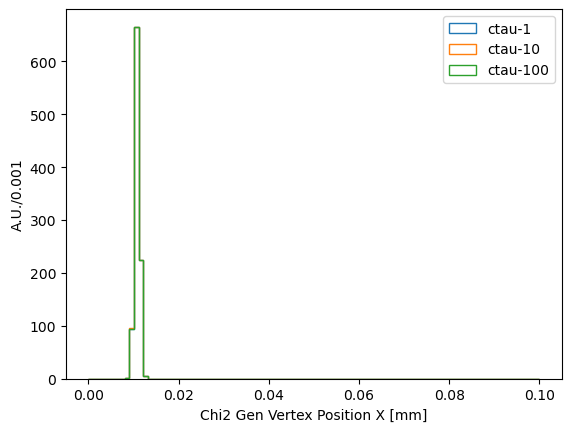

In [105]:
# vx
bins = np.linspace(0,0.1,100)

plt.hist(chi2['ctau-1']['vx'],histtype='step',bins=bins, density=True, label='ctau-1')
plt.hist(chi2['ctau-10']['vx'],histtype='step',bins=bins, density=True, label='ctau-10')
plt.hist(chi2['ctau-100']['vx'],histtype='step',bins=bins, density=True, label='ctau-100')

plt.xlabel("Chi2 Gen Vertex Position X [mm]")
plt.ylabel("A.U./{:.3f}".format(bins[1]-bins[0]))

plt.legend()

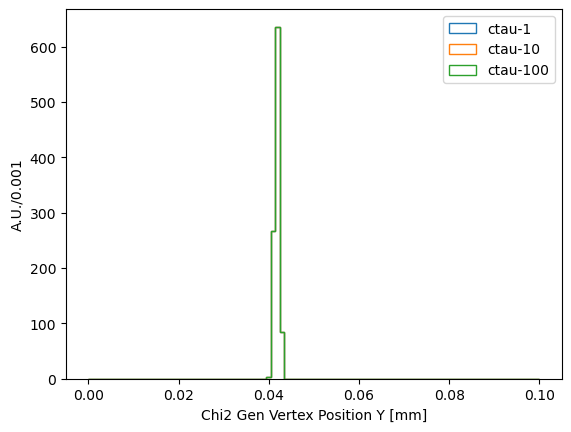

In [106]:
# vy
bins = np.linspace(0,0.1,100)

plt.hist(chi2['ctau-1']['vy'],histtype='step',bins=bins, density=True, label='ctau-1')
plt.hist(chi2['ctau-10']['vy'],histtype='step',bins=bins, density=True, label='ctau-10')
plt.hist(chi2['ctau-100']['vy'],histtype='step',bins=bins, density=True, label='ctau-100')

plt.xlabel("Chi2 Gen Vertex Position Y [mm]")
plt.ylabel("A.U./{:.3f}".format(bins[1]-bins[0]))

plt.legend()

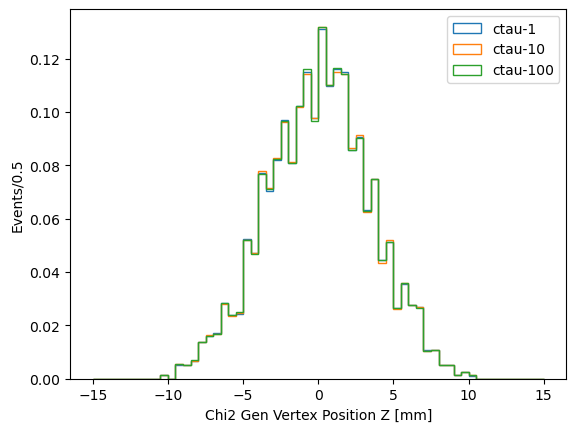

In [19]:
# vz
bins = np.linspace(-15,15,60+1)

plt.hist(chi2['ctau-1']['vz'],histtype='step',bins=bins, density=True, label='ctau-1')
plt.hist(chi2['ctau-10']['vz'],histtype='step',bins=bins, density=True, label='ctau-10')
plt.hist(chi2['ctau-100']['vz'],histtype='step',bins=bins, density=True, label='ctau-100')

plt.xlabel("Chi2 Gen Vertex Position Z [mm]")
plt.ylabel("Events/{:.1f}".format(bins[1]-bins[0]))

plt.legend()

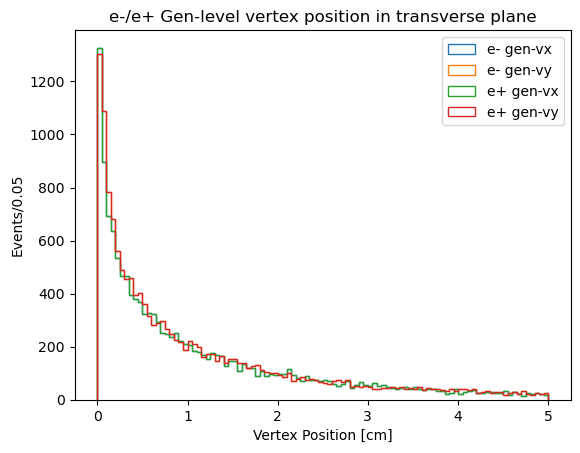

In [111]:
# vx, vy
bins = np.linspace(0,5,100+1)

plt.hist(ele['ctau-10']['vx'],histtype='step',bins=bins, density=False, label='e- gen-vx')
plt.hist(ele['ctau-10']['vy'],histtype='step',bins=bins, density=False, label='e- gen-vy')

plt.hist(pos['ctau-10']['vx'],histtype='step',bins=bins, density=False, label='e+ gen-vx')
plt.hist(pos['ctau-10']['vy'],histtype='step',bins=bins, density=False, label='e+ gen-vy')

plt.xlabel("Vertex Position [cm]")
plt.ylabel("Events/{:.2f}".format(bins[1]-bins[0]))

plt.title('e-/e+ Gen-level vertex position in transverse plane')

plt.legend()

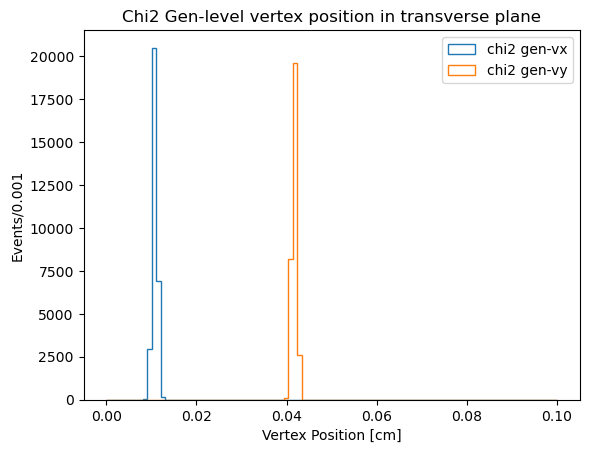

In [110]:
# vx, vy
bins = np.linspace(0,0.1,100)

plt.hist(chi2['ctau-10']['vx'],histtype='step',bins=bins, density=False, label='chi2 gen-vx')
plt.hist(chi2['ctau-10']['vy'],histtype='step',bins=bins, density=False, label='chi2 gen-vy')

plt.xlabel("Vertex Position [cm]")
plt.ylabel("Events/{:.3f}".format(bins[1]-bins[0]))

plt.title('Chi2 Gen-level vertex position in transverse plane')
plt.legend()

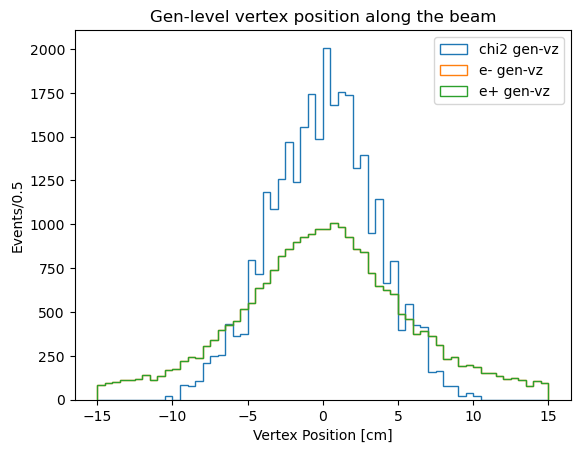

In [112]:
# vz
bins = np.linspace(-15,15,60+1)

plt.hist(chi2['ctau-10']['vz'],histtype='step',bins=bins, density=False, label='chi2 gen-vz')

plt.hist(ele['ctau-10']['vz'],histtype='step',bins=bins,density=False, label='e- gen-vz')
plt.hist(pos['ctau-10']['vz'],histtype='step',bins=bins,density=False, label='e+ gen-vz')

plt.xlabel("Vertex Position [cm]")
plt.ylabel("Events/{:.1f}".format(bins[1]-bins[0]))

plt.title('Gen-level vertex position along the beam')

plt.legend()

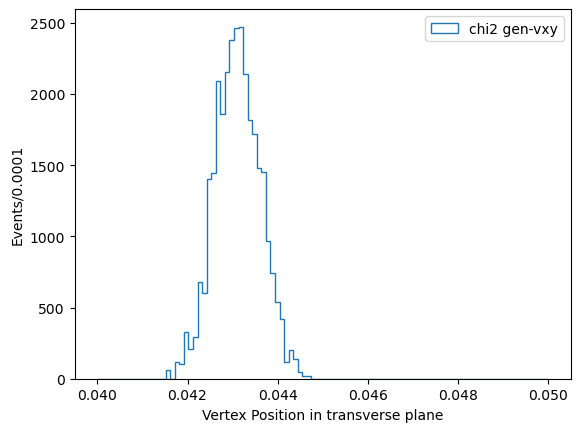

In [169]:
# vxy
bins = np.linspace(0.04,0.05,100)

plt.hist(chi2['vxy'],histtype='step',bins=bins, label='chi2 gen-vxy')

plt.xlabel("Vertex Position in transverse plane")
plt.ylabel("Events/{:.4f}".format(bins[1]-bins[0]))

plt.legend()

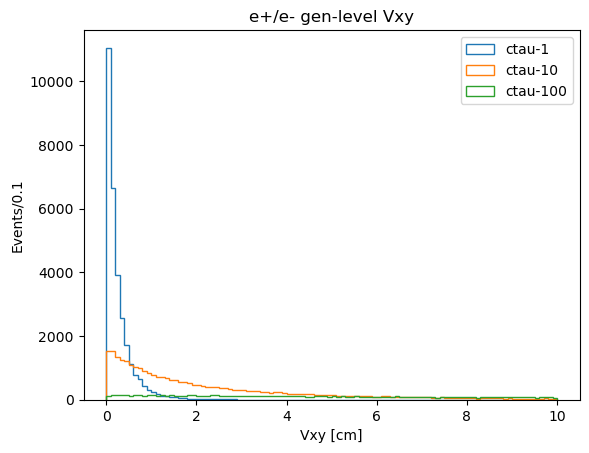

In [130]:
# vxy
bins = np.linspace(0,10,100+1)

plt.hist(ele['ctau-1']['vxy'],histtype='step',bins=bins,density=False, label='ctau-1')
plt.hist(ele['ctau-10']['vxy'],histtype='step',bins=bins,density=False, label='ctau-10')
plt.hist(ele['ctau-100']['vxy'],histtype='step',bins=bins,density=False, label='ctau-100')

plt.xlabel("Vxy [cm]")
plt.ylabel("Events/{:.1f}".format(bins[1]-bins[0]))

plt.title('e+/e- gen-level Vxy')

plt.legend()

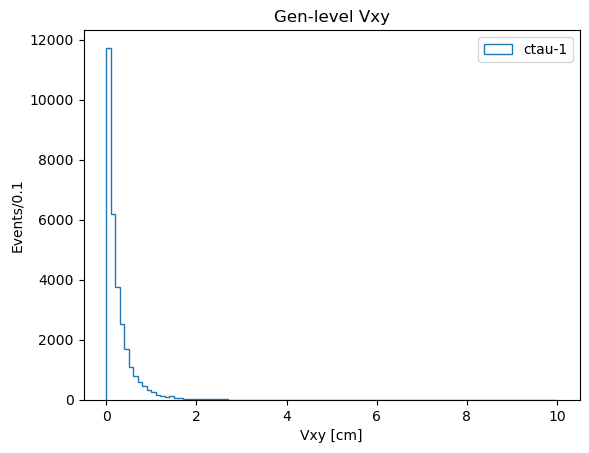

In [129]:
# vxy
bins = np.linspace(0,10,100+1)

plt.hist( np.sqrt((ele['ctau-1']['vx'] - chi2['ctau-1']['vx'])**2 + (ele['ctau-1']['vy'] - chi2['ctau-1']['vy'])**2),\
         histtype='step',bins=bins,density=False, label='ctau-1')

plt.xlabel("Vxy [cm]")
plt.ylabel("Events/{:.1f}".format(bins[1]-bins[0]))

plt.title('Gen-level Vxy')

plt.legend()

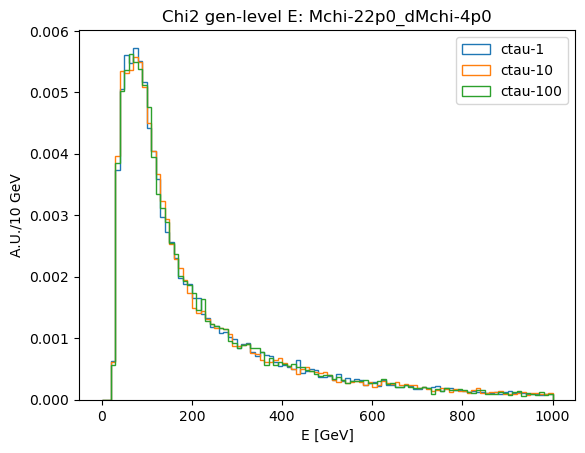

In [116]:
# make a histogram
bins = np.linspace(0,1000,100+1)

plt.hist(chi2['ctau-1']['e'],histtype='step',bins=bins, density=True, label='ctau-1')
plt.hist(chi2['ctau-10']['e'],histtype='step',bins=bins, density=True,  label='ctau-10')
plt.hist(chi2['ctau-100']['e'],histtype='step',bins=bins, density=True,  label='ctau-100')

plt.xlabel("E [GeV]")
plt.ylabel("A.U./{:.0f} GeV".format(bins[1]-bins[0]))

plt.title('Chi2 gen-level E: Mchi-22p0_dMchi-4p0')

plt.legend()

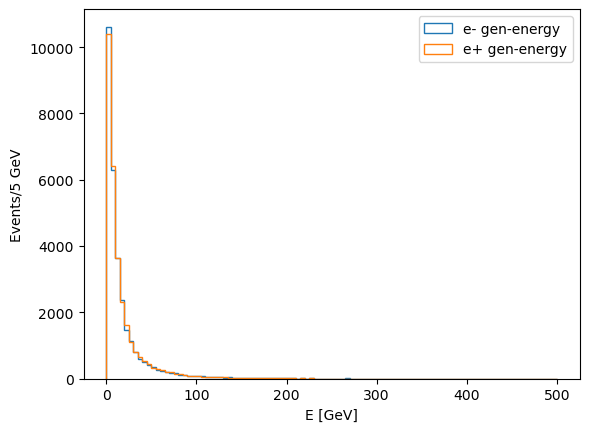

In [185]:
# make a histogram
bins = np.linspace(0,500,100+1)

plt.hist(ele['e'],histtype='step',bins=bins, label='e- gen-energy')
plt.hist(pos['e'],histtype='step',bins=bins, label='e+ gen-energy')

plt.xlabel("E [GeV]")
plt.ylabel("Events/{:.0f} GeV".format(bins[1]-bins[0]))

plt.legend()

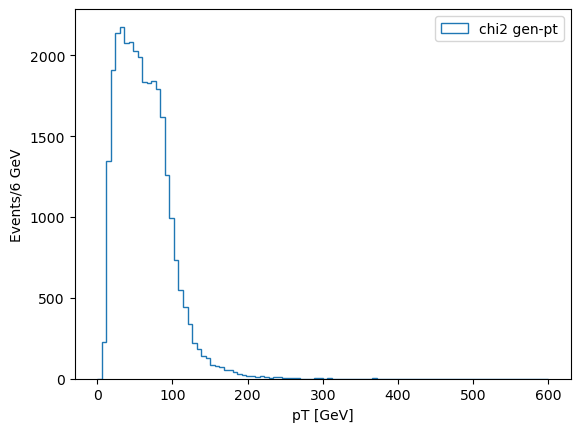

In [190]:
# pt
bins = np.linspace(0,600,100+1)

plt.hist(chi2['pt'],histtype='step',bins=bins, label='chi2 gen-pt')
plt.xlabel("pT [GeV]")
plt.ylabel("Events/{:.0f} GeV".format(bins[1]-bins[0]))

plt.legend()

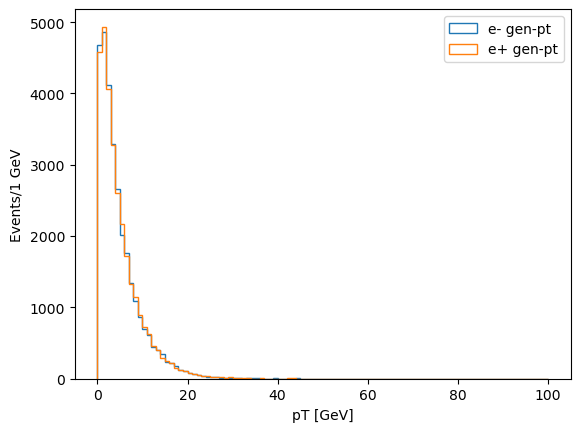

In [192]:
# pt
bins = np.linspace(0,100,100+1)

plt.hist(ele['pt'],histtype='step',bins=bins, label='e- gen-pt')
plt.hist(pos['pt'],histtype='step',bins=bins, label='e+ gen-pt')

plt.xlabel("pT [GeV]")
plt.ylabel("Events/{:.0f} GeV".format(bins[1]-bins[0]))

plt.legend()

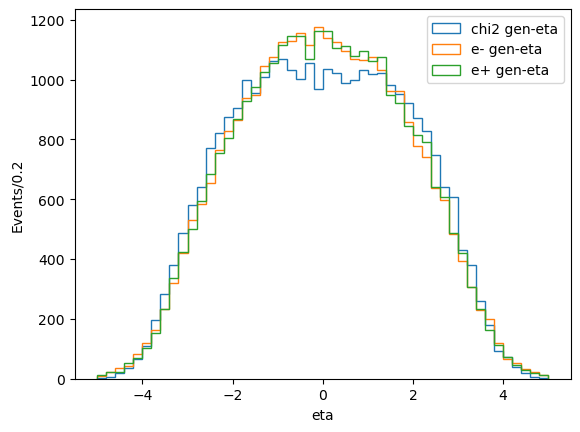

In [193]:
# make a histogram
bins = np.linspace(-5,5,50+1)

plt.hist(chi2['eta'],histtype='step',bins=bins, label='chi2 gen-eta')
plt.hist(ele['eta'],histtype='step',bins=bins, label='e- gen-eta')
plt.hist(pos['eta'],histtype='step',bins=bins, label='e+ gen-eta')

plt.xlabel("eta")
plt.ylabel("Events/{:.1f}".format(bins[1]-bins[0]))

plt.legend()

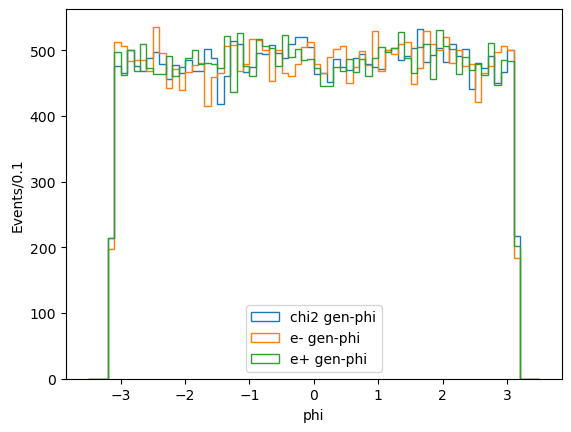

In [194]:
# phi
bins = np.linspace(-3.5,3.5,70+1)

plt.hist(chi2['phi'],histtype='step',bins=bins, label='chi2 gen-phi')
plt.hist(ele['phi'],histtype='step',bins=bins, label='e- gen-phi')
plt.hist(pos['phi'],histtype='step',bins=bins, label='e+ gen-phi')

plt.xlabel("phi")
plt.ylabel("Events/{:.1f}".format(bins[1]-bins[0]))

plt.legend()

In [110]:
mass_chi2

<Array [24, 24, 24, 24, 24, ... 24, 24, 24, 24] type='30486 * float32'>

#### Calculate gamma factor

In [20]:
for ct in ntuples.keys():
    chi2[ct]['gamma'] = chi2[ct]['e']/chi2[ct]['mass']
    ele[ct]['gamma'] = ele[ct]['e']/ele[ct]['mass']
    pos[ct]['gamma'] = pos[ct]['e']/pos[ct]['mass']

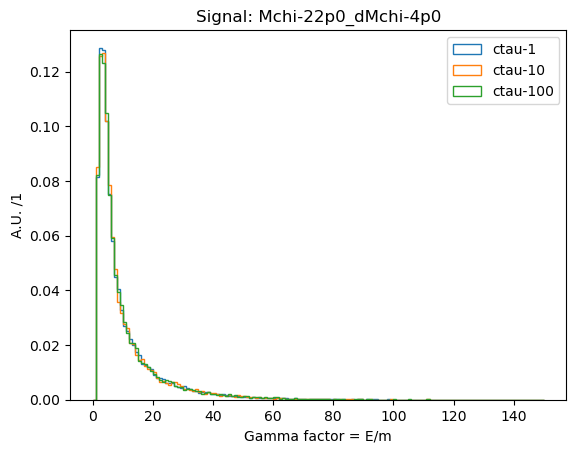

In [119]:
bins = np.linspace(0,150,150+1)

plt.hist(chi2['ctau-1']['gamma'],histtype='step',density=True,bins=bins,label='ctau-1')
plt.hist(chi2['ctau-10']['gamma'],histtype='step',density=True,bins=bins,label='ctau-10')
plt.hist(chi2['ctau-100']['gamma'],histtype='step',density=True,bins=bins,label='ctau-100')
#plt.hist(ele['gamma'],histtype='step',bins=bins,label='e-')
#plt.hist(pos['gamma'],histtype='step',bins=bins,label='e+')

plt.xlabel('Gamma factor = E/m')
plt.ylabel(f'A.U. /{bins[1]-bins[0]:.0f}')
plt.legend()

plt.title('Signal: Mchi-22p0_dMchi-4p0')

plt.show()

#### Calculate decay length of chi2 in the lab frame (= sqrt(vx^2+vy^2+vz^2) of electron)

In [22]:
decayLength = {}

for ctau in ntuples.keys():
    decayLength[ctau] = 10 * np.sqrt( (ele[ctau]['vx']-chi2[ctau]['vx'])**2 + \
                                 (ele[ctau]['vy']-chi2[ctau]['vy'])**2 + \
                                 (ele[ctau]['vz']-chi2[ctau]['vz'])**2)

decayLength

{'ctau-1': <Array [6.58, 3.63, 0.735, ... 0.898, 6.12] type='30280 * float32'>,
 'ctau-10': <Array [71.1, 55.1, 145, ... 51.7, 310, 61.7] type='30486 * float32'>,
 'ctau-100': <Array [226, 488, 701, ... 410, 344, 3.51e+03] type='27497 * float32'>}

Text(0.5, 1.0, 'Signal: Mchi-22p0_dMchi-4p0')

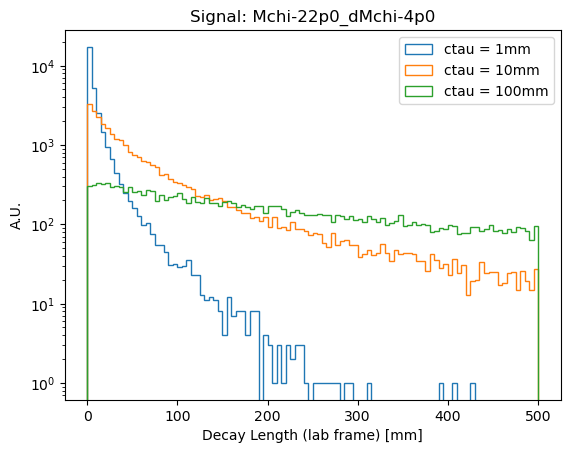

In [141]:
bins = np.linspace(0,500,100+1)

plt.hist(decayLength['ctau-1'],histtype='step',bins=bins,density=False,label='ctau = 1mm')
plt.hist(decayLength['ctau-10'],histtype='step',bins=bins,density=False,label='ctau = 10mm')
plt.hist(decayLength['ctau-100'],histtype='step',bins=bins,density=False,label='ctau = 100mm')

plt.xlabel('Decay Length (lab frame) [mm]')
plt.ylabel('A.U.')

#stats = (f'$\\mu$ = {np.mean(decayLength):.2f}\n'
#        f'$\\sigma$ = {np.std(decayLength):.2f}')
    
#bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
#plt.text(200, 9000, stats, fontsize=9, bbox=bbox, horizontalalignment='right')
plt.yscale('log')

plt.legend()
plt.title('Signal: Mchi-22p0_dMchi-4p0')

Text(0.5, 1.0, 'Signal: Mchi-22p0_dMchi-4p0')

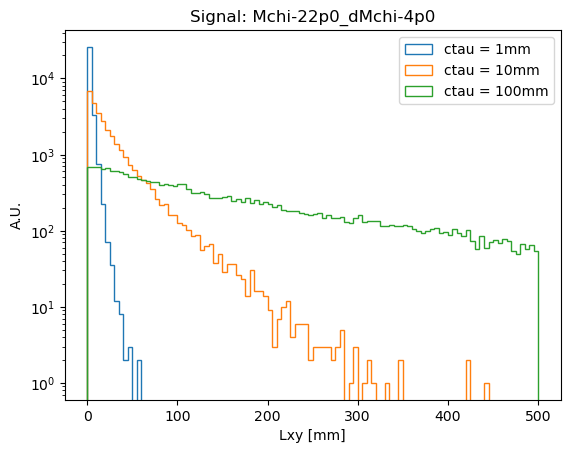

In [155]:
bins = np.linspace(0,500,100+1)

plt.hist(10 * np.sqrt( (ele['ctau-1']['vx']-chi2['ctau-1']['vx'])**2 + (ele['ctau-1']['vy']-chi2['ctau-1']['vy'])**2), \
         histtype='step',bins=bins,density=False,label='ctau = 1mm')
plt.hist(10 * np.sqrt( (ele['ctau-10']['vx']-chi2['ctau-10']['vx'])**2 + (ele['ctau-10']['vy']-chi2['ctau-10']['vy'])**2), \
         histtype='step',bins=bins,density=False,label='ctau = 10mm')
plt.hist(10 * np.sqrt( (ele['ctau-100']['vx']-chi2['ctau-100']['vx'])**2 + (ele['ctau-100']['vy']-chi2['ctau-100']['vy'])**2), \
         histtype='step',bins=bins,density=False,label='ctau = 100mm')

plt.xlabel('Lxy [mm]')
plt.ylabel('A.U.')

#stats = (f'$\\mu$ = {np.mean(decayLength):.2f}\n'
#        f'$\\sigma$ = {np.std(decayLength):.2f}')
    
#bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
#plt.text(200, 9000, stats, fontsize=9, bbox=bbox, horizontalalignment='right')
plt.yscale('log')

plt.legend()
plt.title('Signal: Mchi-22p0_dMchi-4p0')

Text(0.5, 1.0, 'Signal: Mchi-22p0_dMchi-4p0')

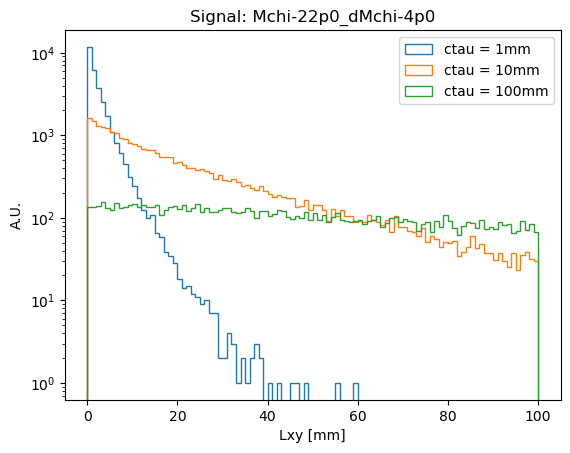

In [156]:
bins = np.linspace(0,100,100+1)

plt.hist(10 * np.sqrt( (ele['ctau-1']['vx']-chi2['ctau-1']['vx'])**2 + (ele['ctau-1']['vy']-chi2['ctau-1']['vy'])**2), \
         histtype='step',bins=bins,density=False,label='ctau = 1mm')
plt.hist(10 * np.sqrt( (ele['ctau-10']['vx']-chi2['ctau-10']['vx'])**2 + (ele['ctau-10']['vy']-chi2['ctau-10']['vy'])**2), \
         histtype='step',bins=bins,density=False,label='ctau = 10mm')
plt.hist(10 * np.sqrt( (ele['ctau-100']['vx']-chi2['ctau-100']['vx'])**2 + (ele['ctau-100']['vy']-chi2['ctau-100']['vy'])**2), \
         histtype='step',bins=bins,density=False,label='ctau = 100mm')

plt.xlabel('Lxy [mm]')
plt.ylabel('A.U.')

#stats = (f'$\\mu$ = {np.mean(decayLength):.2f}\n'
#        f'$\\sigma$ = {np.std(decayLength):.2f}')
    
#bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
#plt.text(200, 9000, stats, fontsize=9, bbox=bbox, horizontalalignment='right')
plt.yscale('log')

plt.legend()
plt.title('Signal: Mchi-22p0_dMchi-4p0')

Text(0.5, 1.0, 'Signal: Mchi-22p0_dMchi-4p0')

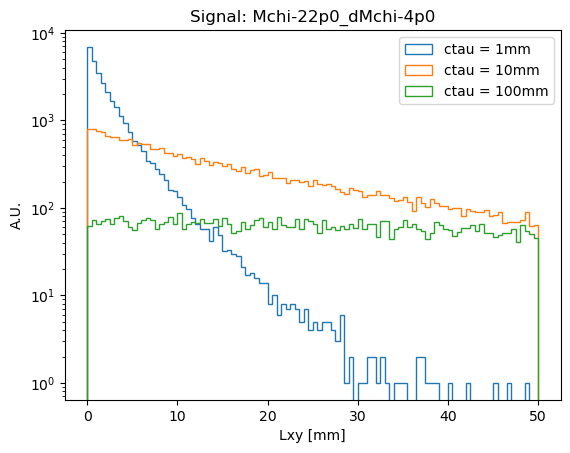

In [157]:
bins = np.linspace(0,50,100+1)

plt.hist(10 * np.sqrt( (ele['ctau-1']['vx']-chi2['ctau-1']['vx'])**2 + (ele['ctau-1']['vy']-chi2['ctau-1']['vy'])**2), \
         histtype='step',bins=bins,density=False,label='ctau = 1mm')
plt.hist(10 * np.sqrt( (ele['ctau-10']['vx']-chi2['ctau-10']['vx'])**2 + (ele['ctau-10']['vy']-chi2['ctau-10']['vy'])**2), \
         histtype='step',bins=bins,density=False,label='ctau = 10mm')
plt.hist(10 * np.sqrt( (ele['ctau-100']['vx']-chi2['ctau-100']['vx'])**2 + (ele['ctau-100']['vy']-chi2['ctau-100']['vy'])**2), \
         histtype='step',bins=bins,density=False,label='ctau = 100mm')

plt.xlabel('Lxy [mm]')
plt.ylabel('A.U.')

#stats = (f'$\\mu$ = {np.mean(decayLength):.2f}\n'
#        f'$\\sigma$ = {np.std(decayLength):.2f}')
    
#bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
#plt.text(200, 9000, stats, fontsize=9, bbox=bbox, horizontalalignment='right')
plt.yscale('log')

plt.legend()
plt.title('Signal: Mchi-22p0_dMchi-4p0')

#### ctau

In [24]:
ctau = {}

for ct in ntuples.keys():
    ctau[ct] = decayLength[ct] / chi2[ct]['gamma']

In [25]:
for ct in ntuples.keys():
    print('{}: max = {:.2f} mm, min = {:.2f} mm, mean = {:.2f} mm'.format(ct, max(ctau[ct]), min(ctau[ct]), np.mean(ctau[ct])))

ctau-1: max = 11.16 mm, min = 0.00 mm, mean = 0.96 mm
ctau-10: max = 105.64 mm, min = 0.00 mm, mean = 9.63 mm
ctau-100: max = 1178.17 mm, min = 0.00 mm, mean = 95.18 mm


Text(0.5, 1.0, 'Signal: Mchi-22p0_dMchi-4p0_ctau-1mm')

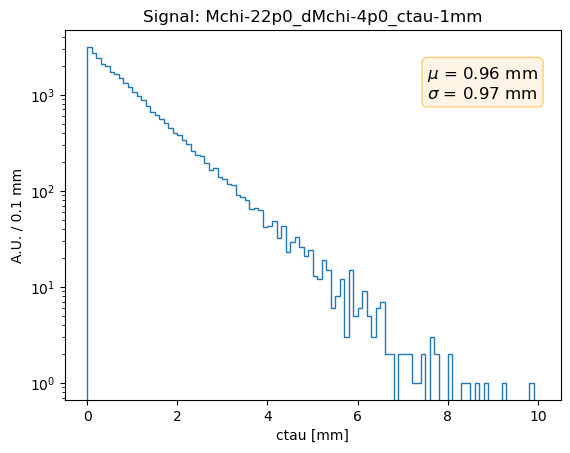

In [131]:
bins = np.linspace(0,10,100+1)

ct_point = 'ctau-1'
ctau_arr = ctau[ct_point]

h_1 = plt.hist(ctau_arr,histtype='step',bins=bins,label=ct_point)

plt.xlabel('ctau [mm]')
plt.ylabel('A.U. / {:.1f} mm'.format(bins[1]-bins[0]))

stats = (f'$\\mu$ = {np.mean(ctau_arr):.2f} mm\n'
        f'$\\sigma$ = {np.std(ctau_arr):.2f} mm')
    
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
plt.text(10, 900, stats, fontsize=12, bbox=bbox, horizontalalignment='right')

plt.yscale('log')
plt.title('Signal: Mchi-22p0_dMchi-4p0_{}mm'.format(ct_point))

In [139]:
np.mean(10* ele['ctau-1']['vxy'])

2.6755067288639367

Text(0.5, 1.0, 'Signal: Mchi-22p0_dMchi-4p0_ctau-1mm')

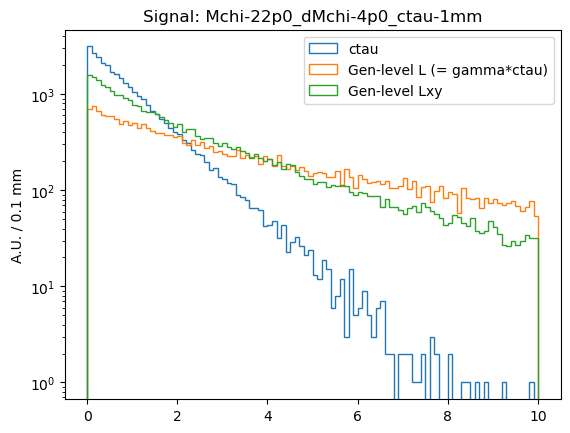

In [149]:
bins = np.linspace(0,10,100+1)

ct_point = 'ctau-1'
ctau_arr = ctau[ct_point]

plt.hist(ctau_arr,histtype='step',bins=bins,label='ctau')
plt.hist(decayLength[ct_point],histtype='step',bins=bins,density=False,label='Gen-level L (= gamma*ctau)')
plt.hist(10 * np.sqrt( (ele[ct_point]['vx']-chi2[ct_point]['vx'])**2 + (ele[ct_point]['vy']-chi2[ct_point]['vy'])**2), \
         histtype='step',bins=bins,density=False,label='Gen-level Lxy')

#plt.xlabel('Decay Length [mm]')
plt.ylabel('A.U. / {:.1f} mm'.format(bins[1]-bins[0]))

plt.yscale('log')

plt.legend()
plt.title('Signal: Mchi-22p0_dMchi-4p0_{}mm'.format(ct_point))

Text(0.5, 1.0, 'Signal: Mchi-22p0_dMchi-4p0_ctau-10mm')

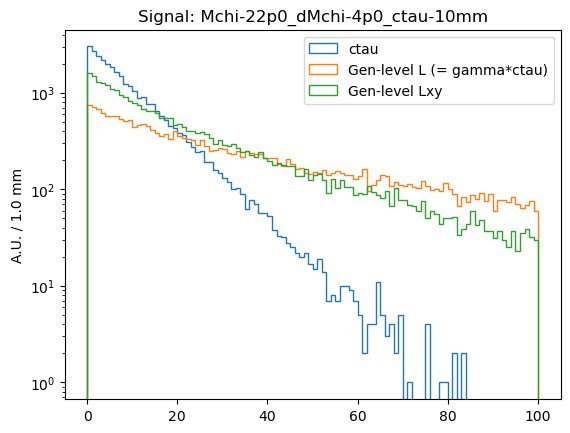

In [151]:
bins = np.linspace(0,100,100+1)

ct_point = 'ctau-10'
ctau_arr = ctau[ct_point]

plt.hist(ctau_arr,histtype='step',bins=bins,label='ctau')
plt.hist(decayLength[ct_point],histtype='step',bins=bins,density=False,label='Gen-level L (= gamma*ctau)')
plt.hist(10 * np.sqrt( (ele[ct_point]['vx']-chi2[ct_point]['vx'])**2 + (ele[ct_point]['vy']-chi2[ct_point]['vy'])**2), \
         histtype='step',bins=bins,density=False,label='Gen-level Lxy')

#plt.xlabel('Decay Length [mm]')
plt.ylabel('A.U. / {:.1f} mm'.format(bins[1]-bins[0]))

plt.yscale('log')

plt.legend()
plt.title('Signal: Mchi-22p0_dMchi-4p0_{}mm'.format(ct_point))

Text(0.5, 1.0, 'Signal: Mchi-22p0_dMchi-4p0_ctau-100mm')

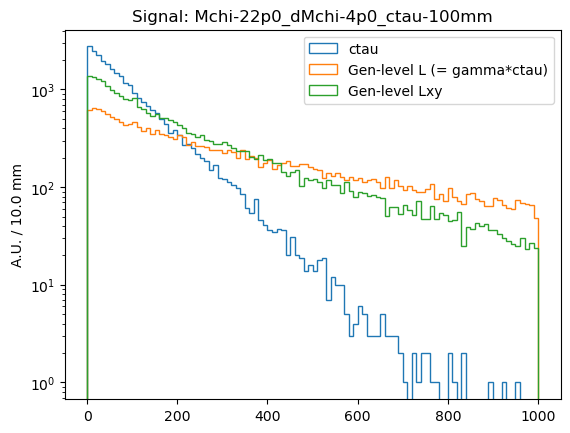

In [153]:
bins = np.linspace(0,1000,100+1)

ct_point = 'ctau-100'
ctau_arr = ctau[ct_point]

plt.hist(ctau_arr,histtype='step',bins=bins,label='ctau')
plt.hist(decayLength[ct_point],histtype='step',bins=bins,density=False,label='Gen-level L (= gamma*ctau)')
plt.hist(10 * np.sqrt( (ele[ct_point]['vx']-chi2[ct_point]['vx'])**2 + (ele[ct_point]['vy']-chi2[ct_point]['vy'])**2), \
         histtype='step',bins=bins,density=False,label='Gen-level Lxy')

#plt.xlabel('Decay Length [mm]')
plt.ylabel('A.U. / {:.1f} mm'.format(bins[1]-bins[0]))

plt.yscale('log')

plt.legend()
plt.title('Signal: Mchi-22p0_dMchi-4p0_{}mm'.format(ct_point))

Text(0.5, 1.0, 'Signal: Mchi-22p0_dMchi-4p0_ctau-10mm')

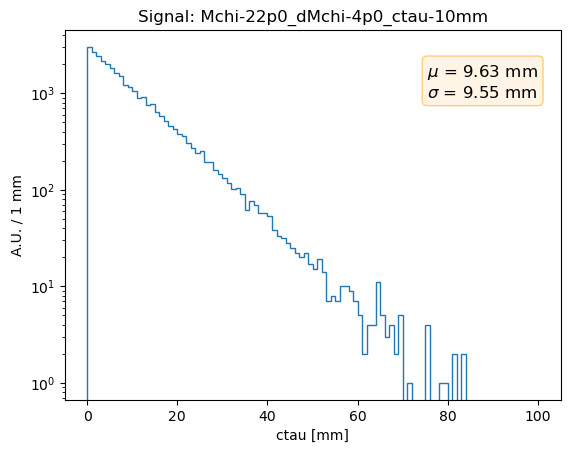

In [30]:
bins = np.linspace(0,100,100+1)

ct_point = 'ctau-10'
ctau_arr = ctau[ct_point]

h_10 = plt.hist(ctau_arr,histtype='step',bins=bins,label=ct_point)

plt.xlabel('ctau [mm]')
plt.ylabel('A.U. / {:.0f} mm'.format(bins[1]-bins[0]))

stats = (f'$\\mu$ = {np.mean(ctau_arr):.2f} mm\n'
        f'$\\sigma$ = {np.std(ctau_arr):.2f} mm')
    
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
plt.text(100, 900, stats, fontsize=12, bbox=bbox, horizontalalignment='right')

plt.yscale('log')
plt.title('Signal: Mchi-22p0_dMchi-4p0_{}mm'.format(ct_point))

Text(0.5, 1.0, 'Signal: Mchi-22p0_dMchi-4p0_ctau-100mm')

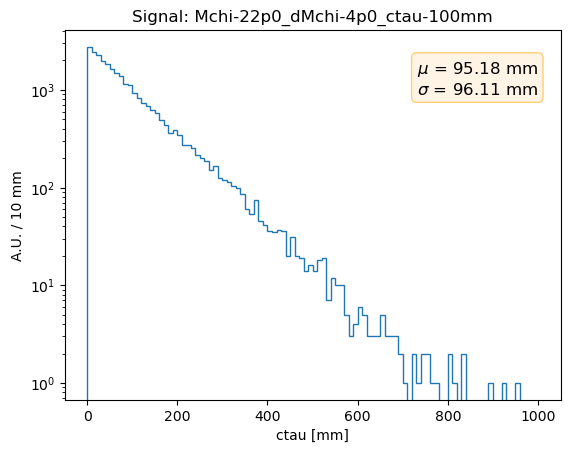

In [31]:
bins = np.linspace(0,1000,100+1)

ct_point = 'ctau-100'
ctau_arr = ctau[ct_point]

h_100 = plt.hist(ctau_arr,histtype='step',bins=bins,label=ct_point)

plt.xlabel('ctau [mm]')
plt.ylabel('A.U. / {:.0f} mm'.format(bins[1]-bins[0]))

stats = (f'$\\mu$ = {np.mean(ctau_arr):.2f} mm\n'
        f'$\\sigma$ = {np.std(ctau_arr):.2f} mm')
    
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
plt.text(1000, 900, stats, fontsize=12, bbox=bbox, horizontalalignment='right')

plt.yscale('log')
plt.title('Signal: Mchi-22p0_dMchi-4p0_{}mm'.format(ct_point))

In [101]:
from scipy.optimize import curve_fit

def exponential(x, a, k, b):
    return a*np.exp(-x*k) + b

/tmp/ipykernel_20604/1079862319.py:4: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-x*k) + b


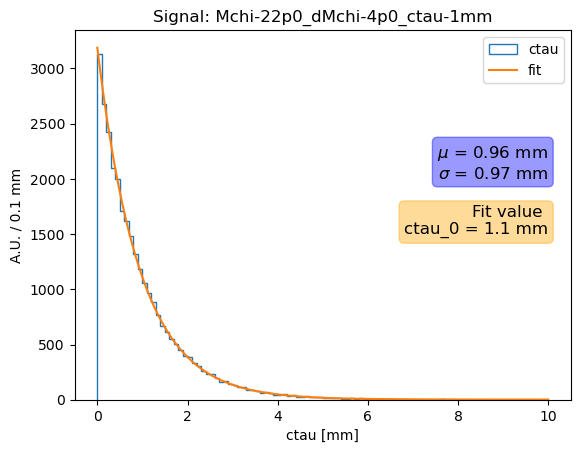

In [102]:
# bin and data
bins = np.linspace(0,10,100+1)

ct_point = 'ctau-1'
ctau_arr = ctau[ct_point]

# hist
bin_heights, bin_borders, _ = plt.hist(ctau_arr, histtype='step', bins=bins, label='ctau')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

# fit
popt, _ = curve_fit(exponential, bin_centers, bin_heights)
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

# label

plt.xlabel('ctau [mm]')
plt.ylabel('A.U. / {:.1f} mm'.format(bins[1]-bins[0]))

# stat box
stats = (f'$\\mu$ = {np.mean(ctau_arr):.2f} mm\n'
        f'$\\sigma$ = {np.std(ctau_arr):.2f} mm')
    
bbox = dict(boxstyle='round', fc='blue', ec='blue', alpha=0.4)
plt.text(10, 2000, stats, fontsize=12, bbox=bbox, horizontalalignment='right')

# fit box
fit_stats = (f'Fit value \nctau_0 = {popt[1]:.1f} mm')
    
fit_bbox = dict(boxstyle='round', fc='orange', ec='orange', alpha=0.4)
plt.text(10, 1500, fit_stats, fontsize=12, bbox=fit_bbox, horizontalalignment='right')

#plt.yscale('log')
plt.title('Signal: Mchi-22p0_dMchi-4p0_{}mm'.format(ct_point))

# plot fit
plt.plot(x_interval_for_fit, exponential(x_interval_for_fit, *popt), label='fit')
plt.legend()

[ 3.15544101e+03  1.03311994e-01 -4.32596409e-01]


/tmp/ipykernel_20604/1079862319.py:4: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-x*k) + b
/tmp/ipykernel_20604/1079862319.py:4: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(-x*k) + b


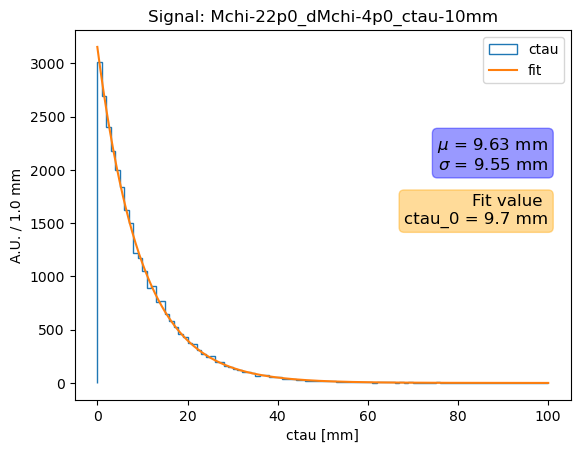

In [103]:
# bin and data
bins = np.linspace(0,100,100+1)

ct_point = 'ctau-10'
ctau_arr = ctau[ct_point]

# hist
bin_heights, bin_borders, _ = plt.hist(ctau_arr, histtype='step', bins=bins, label='ctau')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

# fit
popt, _ = curve_fit(exponential, bin_centers, bin_heights)
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
print(popt)

# label

plt.xlabel('ctau [mm]')
plt.ylabel('A.U. / {:.1f} mm'.format(bins[1]-bins[0]))

# stat box
stats = (f'$\\mu$ = {np.mean(ctau_arr):.2f} mm\n'
        f'$\\sigma$ = {np.std(ctau_arr):.2f} mm')
    
bbox = dict(boxstyle='round', fc='blue', ec='blue', alpha=0.4)
plt.text(100, 2000, stats, fontsize=12, bbox=bbox, horizontalalignment='right')

# fit box
fit_stats = (f'Fit value \nctau_0 = {1/popt[1]:.1f} mm')
    
fit_bbox = dict(boxstyle='round', fc='orange', ec='orange', alpha=0.4)
plt.text(100, 1500, fit_stats, fontsize=12, bbox=fit_bbox, horizontalalignment='right')

#plt.yscale('log')
plt.title('Signal: Mchi-22p0_dMchi-4p0_{}mm'.format(ct_point))

# plot fit
plt.plot(x_interval_for_fit, exponential(x_interval_for_fit, *popt), label='fit')
plt.legend()

[2.91064152e+03 1.06148301e-02 8.90216369e-01]


/tmp/ipykernel_20604/1079862319.py:4: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-x*k) + b


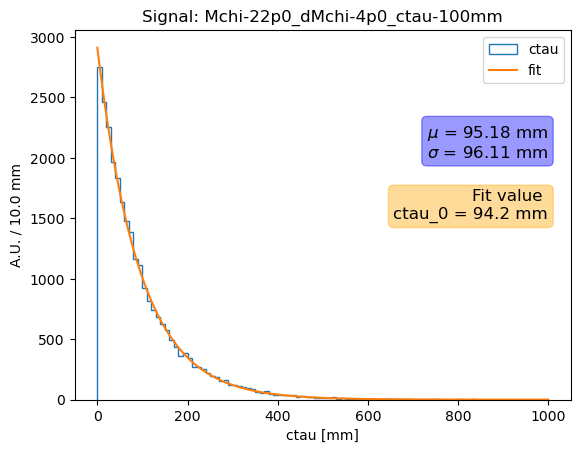

In [104]:
# bin and data
bins = np.linspace(0,1000,100+1)

ct_point = 'ctau-100'
ctau_arr = ctau[ct_point]

# hist
bin_heights, bin_borders, _ = plt.hist(ctau_arr, histtype='step', bins=bins, label='ctau')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

# fit
popt, _ = curve_fit(exponential, bin_centers, bin_heights)
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
print(popt)

# label

plt.xlabel('ctau [mm]')
plt.ylabel('A.U. / {:.1f} mm'.format(bins[1]-bins[0]))

# stat box
stats = (f'$\\mu$ = {np.mean(ctau_arr):.2f} mm\n'
        f'$\\sigma$ = {np.std(ctau_arr):.2f} mm')
    
bbox = dict(boxstyle='round', fc='blue', ec='blue', alpha=0.4)
plt.text(1000, 2000, stats, fontsize=12, bbox=bbox, horizontalalignment='right')

# fit box
fit_stats = (f'Fit value \nctau_0 = {1/popt[1]:.1f} mm')
    
fit_bbox = dict(boxstyle='round', fc='orange', ec='orange', alpha=0.4)
plt.text(1000, 1500, fit_stats, fontsize=12, bbox=fit_bbox, horizontalalignment='right')

#plt.yscale('log')
plt.title('Signal: Mchi-22p0_dMchi-4p0_{}mm'.format(ct_point))

# plot fit
plt.plot(x_interval_for_fit, exponential(x_interval_for_fit, *popt), label='fit')
plt.legend()

Text(0.5, 1.0, 'Signal: Mchi-22p0_dMchi-4p0')

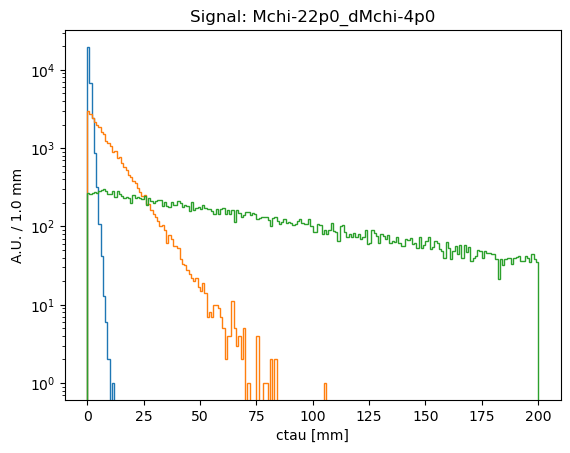

In [126]:
bins = np.linspace(0,200,200+1)

plt.hist(ctau['ctau-1'],histtype='step',bins=bins,label='ctau-1')
plt.hist(ctau['ctau-10'],histtype='step',bins=bins,label='ctau-10')
plt.hist(ctau['ctau-100'],histtype='step',bins=bins,label='ctau-100')

plt.xlabel('ctau [mm]')
plt.ylabel('A.U. / {:.1f} mm'.format(bins[1]-bins[0]))

plt.yscale('log')
plt.title('Signal: Mchi-22p0_dMchi-4p0')